In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.stats import norm
from scipy import stats
from scipy import spatial
from scipy.ndimage import maximum_filter

In [2]:
# Open files containing the residual significance for each pixel:
hdul_hs = fits.open("all_sources_hotspots.fits") # Just the coordinates of each pixel with >= 4 sigma
data_hs = hdul_hs[1].data
hdul_hs.close()
hdul_all = fits.open("all_sources_resiual_ra_dec.fits") # Significances and coordinates of every pixel in our ROI
data_all = hdul_all[1].data
hdul_all.close()
# Retrieve data from the most recent Fermi catalog (LAT 8-year) https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/
fermi = fits.open("gll_psc_v22.fit")
fermi_data = fermi[1].data
cols = fermi[1].columns
fermi.close()


In [3]:
# Filter Fermi catalog by galactic latitude (-4<b<4) and longitude (42<l<65)
latitude_mask = np.logical_and(fermi_data["GLAT"] >= -5, fermi_data["GLAT"] <= 5)
lat_filt = fermi_data[latitude_mask]
long_mask = np.logical_and(lat_filt["GLON"] >= 41, lat_filt["GLON"] <= 66)
fermi_gp = lat_filt[long_mask] # Sources near my region of interest

In [4]:
# Define the coordinates of the sources from the 3HWC Catalog
ps_ras = [297.90, 297.69, 295.05, 294.08, 293.95, 294.39, 292.54, 292.1, 290.79, 288.76, 289.69, 290.17, 290.7, 288.68, 288.06, 286.79]
ps_decs = [26.61, 24.26, 23.77, 22.31, 21.38, 19.31, 18.84, 17.82, 16.96, 16.41, 15.91, 14.79, 14.09, 11.87, 10.35, 8.57]
ps_ls = [61.1, 59.47, 57.76, 56.9, 55.29, 54.03, 52.93, 51.58, 50.19, 50.16, 49.39, 49.01, 46.13, 44.5, 42.35]
ps_bs = [-1.16, 0.67, 0.73, 0.39, -0.98, 0.32, 0.2, 0.89, 2.35, 1.33, 0.39, -0.38, 0.32, 0.15, 0.44]

In [5]:
# Make lists of SkyCoord for easy conversions between galactic l and b and ra and dec
sc_list = SkyCoord(ra=data_hs['ra']*u.degree, dec=data_hs['dec']*u.degree)
sc_all = SkyCoord(ra=data_all['ra']*u.degree, dec=data_all['dec']*u.degree)

In [6]:
# Filter out our new detections (>= 5 sigma), just for fun!
dect_mask = data_hs["sigs"] >= 5
new_detections = data_hs[dect_mask]
new_dects_sc = SkyCoord(ra=new_detections['ra']*u.degree, dec=new_detections['dec']*u.degree)
highsig_mask = data_hs["sigs"] <= 5
high_sigs = data_hs[highsig_mask]
high_sig_sc = SkyCoord(ra=high_sigs['ra']*u.degree, dec=high_sigs['dec']*u.degree)

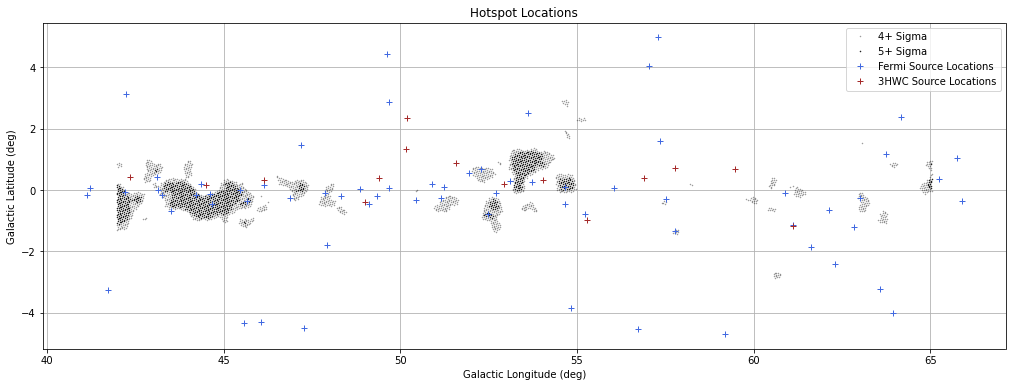

In [7]:
# Plot hotspots, 3HWC source locations, and Fermi source locations
fig, ax = plt.subplots(figsize=(17.25, 6))
plt.plot(high_sig_sc.galactic.l.deg, high_sig_sc.galactic.b.deg, '.', markersize=1, color='k', label="4+ Sigma", alpha=0.4)
plt.plot(new_dects_sc.galactic.l.deg, new_dects_sc.galactic.b.deg, '.', markersize=1, color='k', label="5+ Sigma")
plt.plot(fermi_gp['GLON'], fermi_gp['GLAT'], '+', color="royalblue", label="Fermi Source Locations")
plt.plot(ps_ls, ps_bs, '+', label="3HWC Source Locations", color="brown")
plt.xlabel("Galactic Longitude (deg)")
plt.ylabel("Galactic Latitude (deg)")
plt.title("Hotspot Locations")
plt.grid(visible=True, which='both')
plt.legend()
#plt.savefig("highSigandSources.png")

In [8]:
# Find the local maxima as the locations of our hotspots: filtering twice gives the best maxima 
neighborhood_size = 4 # Look at the n surrounding values
max_vals = maximum_filter(data_all['sigs'], neighborhood_size, mode='constant')
max_coords1 = data_all[np.logical_and(data_all['sigs'] == max_vals, max_vals >= 4)]
neighborhood_size = 8 # Look at the n surrounding values
max_vals = maximum_filter(max_coords1['sigs'], neighborhood_size, mode='constant')
max_coords2 = max_coords1[np.logical_and(max_coords1['sigs'] == max_vals, max_vals >= 4)]
maxima_sc = SkyCoord(ra=max_coords2['ra']*u.degree, dec=max_coords2['dec']*u.degree)

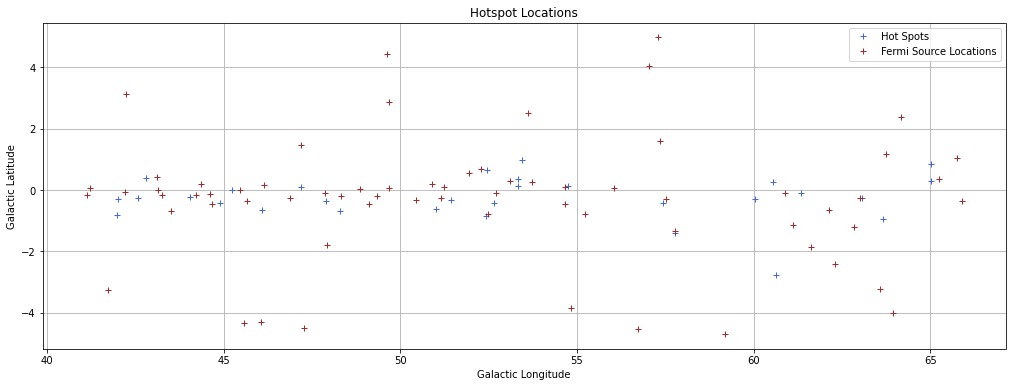

In [9]:
# Plot the maxima and Fermi source locations. Looks promising
fig, ax = plt.subplots(figsize=(17.25, 6))
plt.plot(maxima_sc.galactic.l.deg, maxima_sc.galactic.b.deg, '+', color='royalblue', label="Hot Spots")
plt.plot(fermi_gp['GLON'], fermi_gp['GLAT'], '+', color="brown", label="Fermi Source Locations")
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
plt.title("Hotspot Locations")
plt.grid(visible=True, which='both')
plt.legend()
plt.savefig("maximaLocationsandFermi.png")

In [10]:
# Make skycoord list for Fermi sources
fermi_sc = SkyCoord(ra=fermi_gp['RAJ2000']*u.degree, dec=fermi_gp['DEJ2000']*u.degree)

In [11]:
# Create cKDTree objects for the coordinates
fermi_coords = np.transpose(np.array([fermi_sc.galactic.l.deg, fermi_sc.galactic.b.deg]))
fermi_tree = spatial.cKDTree(fermi_coords)
hs_coords = np.transpose(np.array([maxima_sc.galactic.l.deg, maxima_sc.galactic.b.deg]))
hs_tree = spatial.cKDTree(hs_coords)

In [12]:
# Count the number of neighbors within dists[i] and dists[i+1]:
dists = np.linspace(0, 10, 41)
pairs = hs_tree.count_neighbors(fermi_tree, dists, cumulative=False)
# Get centers of bins:
centers = np.zeros(len(dists)-1)
for i in range(len(dists)-1):
    centers[i] = (dists[i]+dists[i+1])/2

In [13]:
# We need something to compare this to. Create the random data by shuffling the galactic latitude and longitude
# Shuffle the fermi data
flong_shuffle = fermi_sc.galactic.l.deg
flat_shuffle = fermi_sc.galactic.b.deg
np.random.shuffle(flong_shuffle)
np.random.shuffle(flat_shuffle)
fermi_rand_tree = spatial.cKDTree(np.transpose([flong_shuffle, flat_shuffle]))
# Shuffle the hotspots
hlong_shuffle = maxima_sc.galactic.l.deg
hlat_shuffle = maxima_sc.galactic.b.deg
np.random.shuffle(hlong_shuffle)
np.random.shuffle(hlat_shuffle)
hawc_rand_tree = spatial.cKDTree(np.transpose([hlong_shuffle, hlat_shuffle]))
# Count the number of pairs in the random data, using the same bins as before
rand_pairs = hawc_rand_tree.count_neighbors(fermi_rand_tree, dists, cumulative=False)

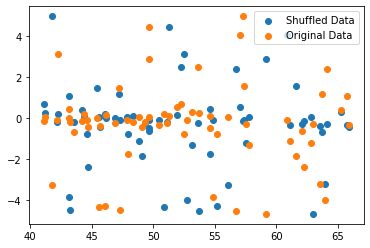

In [14]:
# Show that it does not destroy the data's tendency to cluster to the galactic plane
plt.figure(2)
plt.scatter(flong_shuffle, flat_shuffle, label="Shuffled Data")
plt.scatter(fermi_sc.galactic.l.deg, fermi_sc.galactic.b.deg, label="Original Data")
plt.legend()

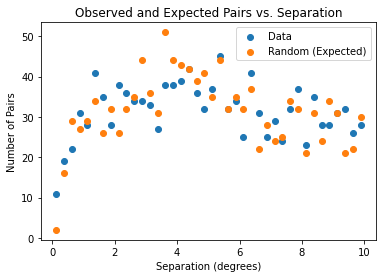

In [15]:
# Plot of observed vs. expected
plt.figure(3)
plt.scatter(centers, pairs[1:], label="Data")
plt.scatter(centers, rand_pairs[1:], label="Random (Expected)")
plt.legend()
plt.xlabel("Separation (degrees)")
plt.ylabel("Number of Pairs")
plt.title("Observed and Expected Pairs vs. Separation")
plt.savefig("pairs.png")

In [16]:
# BOOTSTRAP BILL MADE A VERY HANDSOME SON

In [17]:
# Do bootstrap sampling of the data and reshuffle each time
dists = np.linspace(0, 10, 41)
n_bootstraps = 500
data_pairs = np.zeros((n_bootstraps, len(dists)))
rand_pairs = np.zeros((n_bootstraps, len(dists)))
for i in range(n_bootstraps):
    # Draw random indices to create the bootstrapped sample
    hs_indices = np.random.randint(0, len(maxima_sc), len(maxima_sc))
    fermi_indices = np.random.randint(0, len(fermi_sc), len(fermi_sc))
    
    # Retrieve the corresponding coordinates for my hotspots
    temp_ra = np.zeros(len(maxima_sc))
    temp_dec = np.zeros(len(maxima_sc))
    for n in range(len(hs_indices)):
        temp_ra[n] = maxima_sc[hs_indices[n]].ra.deg
        temp_dec[n] = maxima_sc[hs_indices[n]].dec.deg
    hs_b = SkyCoord(ra=temp_ra*u.degree, dec=temp_dec*u.degree)
    
    # Retrieve the corresponding coordinates for Fermi
    temp_ra = np.zeros(len(fermi_sc))
    temp_dec = np.zeros(len(fermi_sc))
    for m in range(len(fermi_indices)):
        temp_ra[m] = fermi_sc[fermi_indices[m]].ra.deg
        temp_dec[m] = fermi_sc[fermi_indices[m]].dec.deg
    fermi_b = SkyCoord(ra=temp_ra*u.degree, dec=temp_dec*u.degree)
    
    # Define the trees
    fermi_coords = np.transpose(np.array([fermi_b.galactic.b.deg, fermi_b.galactic.l.deg]))
    fermi_tree = spatial.cKDTree(fermi_coords)
    hs_coords = np.transpose(np.array([hs_b.galactic.b.deg, hs_b.galactic.l.deg]))
    hs_tree = spatial.cKDTree(hs_coords)
    # Count the pairs
    data_pairs[i] = hs_tree.count_neighbors(fermi_tree, dists, cumulative=False)
    
    # Shuffle the bootstrapped sample
    flong_shuffle = fermi_b.galactic.l.deg
    flat_shuffle = fermi_b.galactic.b.deg
    np.random.shuffle(flong_shuffle)
    np.random.shuffle(flat_shuffle)
    fermi_rand_tree = spatial.cKDTree(np.transpose([flong_shuffle, flat_shuffle]))
    hlong_shuffle = hs_b.galactic.l.deg
    hlat_shuffle = hs_b.galactic.b.deg
    np.random.shuffle(hlong_shuffle)
    np.random.shuffle(hlat_shuffle)
    hawc_rand_tree = spatial.cKDTree(np.transpose([hlong_shuffle, hlat_shuffle]))
    # Count the number of pairs in the shuffled sample
    rand_pairs[i] = hawc_rand_tree.count_neighbors(fermi_rand_tree, dists, cumulative=False)

In [18]:
# Correlation function (DD/RR-1) might be easier to understand
corr_func = np.zeros((n_bootstraps, len(dists)))
for i in range(n_bootstraps):
    for j in range(len(dists)):
        if rand_pairs[i, j] != 0:
            corr_func[i, j] = (data_pairs[i, j]/rand_pairs[i, j]) - 1

In [19]:
# Then the uncertainty in our sample is the standard deviation and out best estimator is the mean for each dist
rand_means = np.zeros(len(dists))
rand_sig = np.zeros(len(dists))
data_means = np.zeros(len(dists))
data_sig = np.zeros(len(dists))
corr_means = np.zeros(len(dists))
corr_sig = np.zeros(len(dists))
for i in range(len(dists)):
    rand_means[i] = np.mean(rand_pairs[:,i])
    rand_sig[i] = np.std(rand_pairs[:,i], ddof=1)
    data_means[i] = np.mean(data_pairs[:,i])
    data_sig[i] = np.std(data_pairs[:,i], ddof=1)
    corr_means[i] = np.mean(corr_func[:, i])
    corr_sig[i] = np.std(corr_func[:, i], ddof=1)

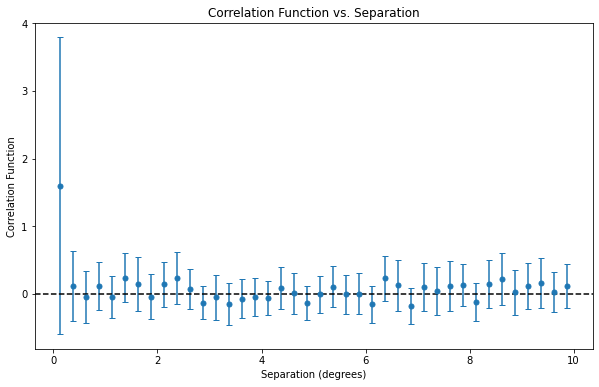

In [20]:
# Plot the correlation function with error bars
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(centers, corr_means[1:], yerr=corr_sig[1:], capsize=3, marker='.', markersize=10, linestyle="")
plt.axhline(0, linestyle="--", color='black')
plt.xlabel("Separation (degrees)")
plt.ylabel("Correlation Function")
plt.title("Correlation Function vs. Separation")
plt.savefig("bootstrapped_corr.png")